In [2]:
import os, re, copy
import numpy as np
import pandas as pd
import seaborn as sns
import yfinance as yf
import datetime 
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
%matplotlib inline

### Parameters

### Dataset


#### Sentiment dataset

Trying to include all the sentiment dataset

https://stackoverflow.com/questions/4666973/how-to-extract-the-substring-between-two-markers

Example

In [60]:
rootdir = "../data"
regex = re.compile('(GE_*)')

filenames = []
colnames = []
for root, dirs, files in os.walk(rootdir):
  for file in files:
    # Extract file name
    if regex.match(file):
      filenames.append(file)
      
      # Extract dataset name
      found = re.search(r"(?<=GE_).*?(?=\.csv)", file).group(0)
      
      if found:
        phrases = found.split('_')
        if 'Llama' in phrases[1]:
            colname = f'{phrases[1]}-{phrases[-2]}-{phrases[-1]}' #, reg.group(1)
            
        else:
            colname = f'{phrases[1]}-{phrases[-1]}'
        colnames.append(colname)
        
colnames

['Llama-2-7B-GPTQ-fullarticles',
 'Llama-2-70B-GPTQ-headlines',
 'Llama-3-70B-GPTQ-fullarticles',
 'GPT3.5-headlines',
 'Llama-2-70B-GPTQ-fullarticles',
 'finBERT-headlines',
 'Llama-3-8B-GPTQ-fullarticles',
 'Llama-3-70B-GPTQ-headlines',
 'Llama-2-13B-GPTQ-fullarticles',
 'Llama-2-7B-GPTQ-headlines',
 'Llama-2-13b-GGUF-fullarticles',
 'Llama-3-8B-GPTQ-headlines',
 'Llama-2-13B-GPTQ-headlines']

In [61]:
data_list = []
for i in range(len(filenames)):
    dat = pd.read_csv(f'{rootdir}/{filenames[i]}', dtype={'Sentiment': float, 'Stock_symbol': str, 'Url': str}, parse_dates=['Date']).drop(['Stock_symbol', 'Url'], axis=1).set_index(['Date']).rename(columns={"Sentiment": colnames[i]})
    data_list.append(dat)
    
merged_df = pd.concat(data_list, axis=1)
merged_df

,Llama-2-7B-GPTQ-fullarticles,Llama-2-70B-GPTQ-headlines,Llama-3-70B-GPTQ-fullarticles,GPT3.5-headlines,Llama-2-70B-GPTQ-fullarticles,finBERT-headlines,Llama-3-8B-GPTQ-fullarticles,Llama-3-70B-GPTQ-headlines,Llama-2-13B-GPTQ-fullarticles,Llama-2-7B-GPTQ-headlines,Llama-2-13b-GGUF-fullarticles,Llama-3-8B-GPTQ-headlines,Llama-2-13B-GPTQ-headlines
Date,,,,,,,,,,,,,
2023-12-16 21:00:00+00:00,3.0,3.0,4.0,4.0,4.0,4.856880,4.0,3.0,2.0,4.0,4.0,4.0,3.0
2023-12-16 00:00:00+00:00,4.0,4.0,5.0,5.0,4.0,4.722641,4.0,5.0,4.0,3.0,4.0,4.0,3.0
2023-12-16 00:00:00+00:00,3.0,3.0,4.0,3.0,4.0,3.151579,3.0,3.0,4.0,3.0,4.0,3.0,3.0
2023-12-16 00:00:00+00:00,3.0,4.0,4.0,4.0,2.0,4.663424,0.0,3.0,3.0,4.0,4.0,3.0,3.0
2023-12-15 00:00:00+00:00,4.0,3.0,4.0,3.0,4.0,2.593138,3.0,3.0,3.0,3.0,4.0,3.0,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2012-04-23 00:00:00+00:00,4.0,4.0,4.0,5.0,4.0,3.744149,4.0,5.0,3.0,4.0,3.0,4.0,4.0
2012-04-23 00:00:00+00:00,3.0,3.0,4.0,3.0,3.0,2.466803,3.0,3.0,4.0,3.0,4.0,3.0,3.0
2012-04-20 00:00:00+00:00,4.0,4.0,5.0,4.0,4.0,3.857823,4.0,4.0,4.0,4.0,4.0,3.0,3.0


There are no missing values

In [62]:
merged_df.isna().sum()

Llama-2-7B-GPTQ-fullarticles     0
Llama-2-70B-GPTQ-headlines       0
Llama-3-70B-GPTQ-fullarticles    0
GPT3.5-headlines                 0
Llama-2-70B-GPTQ-fullarticles    0
finBERT-headlines                0
Llama-3-8B-GPTQ-fullarticles     0
Llama-3-70B-GPTQ-headlines       0
Llama-2-13B-GPTQ-fullarticles    0
Llama-2-7B-GPTQ-headlines        0
Llama-2-13b-GGUF-fullarticles    0
Llama-3-8B-GPTQ-headlines        0
Llama-2-13B-GPTQ-headlines       0
dtype: int64

Compare mean and range of values among the results

In [63]:
merged_df.describe()

,Llama-2-7B-GPTQ-fullarticles,Llama-2-70B-GPTQ-headlines,Llama-3-70B-GPTQ-fullarticles,GPT3.5-headlines,Llama-2-70B-GPTQ-fullarticles,finBERT-headlines,Llama-3-8B-GPTQ-fullarticles,Llama-3-70B-GPTQ-headlines,Llama-2-13B-GPTQ-fullarticles,Llama-2-7B-GPTQ-headlines,Llama-2-13b-GGUF-fullarticles,Llama-3-8B-GPTQ-headlines,Llama-2-13B-GPTQ-headlines
count,8680.000000,8680.000000,8680.000000,8680.000000,8680.000000,8680.000000,8680.000000,8680.000000,8680.000000,8680.000000,8680.000000,8680.000000,8680.000000
mean,3.245622,3.066590,3.268203,3.331452,2.999654,2.614096,2.778571,3.217281,3.181452,3.258065,3.308525,2.711982,2.997811
std,0.636879,0.904057,1.217533,1.053660,1.040542,1.147998,1.219556,1.008445,0.709361,0.458175,0.721964,1.012763,0.408877
min,1.000000,1.000000,0.000000,1.000000,0.000000,0.078855,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,1.000000
25%,3.000000,3.000000,2.000000,3.000000,3.000000,2.445793,2.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000
50%,3.000000,3.000000,4.000000,3.000000,3.000000,2.560233,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000
75%,4.000000,4.000000,4.000000,4.000000,4.000000,2.954813,4.000000,4.000000,4.000000,4.000000,4.000000,3.000000,3.000000
max,5.000000,5.000000,5.000000,5.000000,7.000000,4.857064,50.000000,5.000000,7.000000,5.000000,7.000000,5.000000,5.000000


Check value distribution

In [64]:
for column in merged_df.columns: #[:-1]
    print(merged_df[column].value_counts())

Llama-2-7B-GPTQ-fullarticles
3.0    5440
4.0    2378
2.0     594
5.0     221
1.0      47
Name: count, dtype: int64
Llama-2-70B-GPTQ-headlines
3.0    4812
4.0    2569
1.0     989
2.0     211
5.0      99
Name: count, dtype: int64
Llama-3-70B-GPTQ-fullarticles
4.0    3614
3.0    1728
2.0    1287
5.0    1045
1.0     929
0.0      77
Name: count, dtype: int64
GPT3.5-headlines
3.0    3089
4.0    2813
5.0    1127
2.0    1112
1.0     539
Name: count, dtype: int64
Llama-2-70B-GPTQ-fullarticles
3.0    3383
4.0    2998
1.0    1182
2.0     948
5.0     161
0.0       6
7.0       1
6.0       1
Name: count, dtype: int64
finBERT-headlines
2.491283    31
2.591554    24
2.367193    19
2.593138    16
2.648294    16
            ..
2.534693     1
2.522934     1
2.982258     1
2.488833     1
2.524730     1
Name: count, Length: 8105, dtype: int64
Llama-3-8B-GPTQ-fullarticles
3.0     3597
4.0     2292
2.0     1288
1.0     1276
0.0      185
5.0       32
10.0       7
50.0       1
7.0        1
20.0       1
Name: c

Change zero values as 1, values > 5 as 5

In [65]:
merged_df[merged_df==0] = 1
merged_df[merged_df > 5] = 5
for column in merged_df.columns: #[:-1]
    print(merged_df[column].value_counts())

Llama-2-7B-GPTQ-fullarticles
3.0    5440
4.0    2378
2.0     594
5.0     221
1.0      47
Name: count, dtype: int64
Llama-2-70B-GPTQ-headlines
3.0    4812
4.0    2569
1.0     989
2.0     211
5.0      99
Name: count, dtype: int64
Llama-3-70B-GPTQ-fullarticles
4.0    3614
3.0    1728
2.0    1287
5.0    1045
1.0    1006
Name: count, dtype: int64
GPT3.5-headlines
3.0    3089
4.0    2813
5.0    1127
2.0    1112
1.0     539
Name: count, dtype: int64
Llama-2-70B-GPTQ-fullarticles
3.0    3383
4.0    2998
1.0    1188
2.0     948
5.0     163
Name: count, dtype: int64
finBERT-headlines
2.491283    31
2.591554    24
2.367193    19
2.593138    16
2.648294    16
            ..
2.534693     1
2.522934     1
2.982258     1
2.488833     1
2.524730     1
Name: count, Length: 8105, dtype: int64
Llama-3-8B-GPTQ-fullarticles
3.0    3597
4.0    2292
1.0    1461
2.0    1288
5.0      42
Name: count, dtype: int64
Llama-3-70B-GPTQ-headlines
3.0    4601
4.0    1883
5.0     979
1.0     735
2.0     482
Name: count,

Time stamps of sentiment data are in GMT+0 timezone

In [8]:
merged_df.index[0]

Timestamp('2023-12-16 21:00:00+0000', tz='UTC')

In [66]:
def date_extract(timestamp):
    match_str = re.search(r'\d{4}-\d{2}-\d{2}', str(timestamp))
    res = datetime.datetime.strptime(match_str.group(), '%Y-%m-%d').date()
    return res
    

In [67]:
# match_str = [re.search(r'\d{4}-\d{2}-\d{2}', str(x)) for x in merged_df.index]
# res = [datetime.datetime.strptime(x.group(), '%Y-%m-%d').date() for x in match_str]
merged_df['Time'] = [date_extract(x) for x in merged_df.index]
merged_df.head()

,Llama-2-7B-GPTQ-fullarticles,Llama-2-70B-GPTQ-headlines,Llama-3-70B-GPTQ-fullarticles,GPT3.5-headlines,Llama-2-70B-GPTQ-fullarticles,finBERT-headlines,Llama-3-8B-GPTQ-fullarticles,Llama-3-70B-GPTQ-headlines,Llama-2-13B-GPTQ-fullarticles,Llama-2-7B-GPTQ-headlines,Llama-2-13b-GGUF-fullarticles,Llama-3-8B-GPTQ-headlines,Llama-2-13B-GPTQ-headlines,Time
Date,,,,,,,,,,,,,,
2023-12-16 21:00:00+00:00,3.0,3.0,4.0,4.0,4.0,4.856880,4.0,3.0,2.0,4.0,4.0,4.0,3.0,2023-12-16
2023-12-16 00:00:00+00:00,4.0,4.0,5.0,5.0,4.0,4.722641,4.0,5.0,4.0,3.0,4.0,4.0,3.0,2023-12-16
2023-12-16 00:00:00+00:00,3.0,3.0,4.0,3.0,4.0,3.151579,3.0,3.0,4.0,3.0,4.0,3.0,3.0,2023-12-16
2023-12-16 00:00:00+00:00,3.0,4.0,4.0,4.0,2.0,4.663424,1.0,3.0,3.0,4.0,4.0,3.0,3.0,2023-12-16
2023-12-15 00:00:00+00:00,4.0,3.0,4.0,3.0,4.0,2.593138,3.0,3.0,3.0,3.0,4.0,3.0,3.0,2023-12-15


Reduce sentiment score by day.

First attempt: simple average.

In [68]:
sent_daily = merged_df.groupby(['Time']).mean()
sent_daily

,Llama-2-7B-GPTQ-fullarticles,Llama-2-70B-GPTQ-headlines,Llama-3-70B-GPTQ-fullarticles,GPT3.5-headlines,Llama-2-70B-GPTQ-fullarticles,finBERT-headlines,Llama-3-8B-GPTQ-fullarticles,Llama-3-70B-GPTQ-headlines,Llama-2-13B-GPTQ-fullarticles,Llama-2-7B-GPTQ-headlines,Llama-2-13b-GGUF-fullarticles,Llama-3-8B-GPTQ-headlines,Llama-2-13B-GPTQ-headlines
Time,,,,,,,,,,,,,
2012-04-20,3.666667,3.333333,4.666667,3.333333,3.333333,2.935755,3.666667,3.333333,3.666667,4.000000,3.666667,3.000000,3.000000
2012-04-23,3.333333,3.333333,3.666667,3.666667,3.333333,2.869610,3.333333,3.666667,3.333333,3.333333,3.333333,3.333333,3.333333
2012-04-24,3.000000,4.000000,3.000000,4.000000,3.000000,2.634394,3.000000,3.000000,4.000000,3.000000,4.000000,4.000000,3.000000
2012-04-26,3.000000,3.000000,3.000000,3.000000,3.000000,0.777762,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000
2012-04-30,3.000000,3.000000,3.000000,3.000000,4.000000,2.604599,3.000000,3.000000,4.000000,3.000000,4.000000,3.000000,3.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-11,3.000000,2.800000,3.200000,2.800000,3.200000,2.441272,2.400000,2.600000,2.800000,3.400000,3.200000,2.400000,2.800000
2023-12-12,3.750000,3.375000,4.125000,3.750000,3.500000,2.958181,3.375000,3.500000,3.750000,3.250000,3.750000,3.250000,3.125000
2023-12-13,3.833333,3.666667,3.666667,4.000000,3.666667,3.125993,3.166667,4.000000,3.500000,3.500000,3.666667,3.500000,3.000000


#### Stock price data

In [137]:
start_date = sent_daily.index[0]
end_date = sent_daily.index[-1]

stock_price = yf.Ticker('GE').history(start=start_date, end=end_date, period="1day", auto_adjust=False, actions=False)[['Adj Close']]

NameError: name 'sent_daily' is not defined

Time stamps of GE are in GMT-4/-5 timezone

In [75]:
stock_price.index[0]

Timestamp('2012-04-20 00:00:00-0400', tz='America/New_York')

In [76]:
stock_price['Time'] = [date_extract(x) for x in stock_price.index]
print('Number of duplication in time: ', sum(stock_price['Time'].value_counts() >1))

Number of duplication in time:  0


In [77]:
stock_price.index = stock_price['Time']
stock_price.head()

,Adj Close,Time
Time,,
2012-04-20,68.549644,2012-04-20
2012-04-23,67.522797,2012-04-23
2012-04-24,69.186981,2012-04-24
2012-04-25,68.868301,2012-04-25
2012-04-26,69.470253,2012-04-26


In [ ]:
stock_price['Per_ret'] = stock_price['Adj Close'].pct_change()
# stock_price = stock_price[['Adj Close']]


#### Fama-French 3 factors

https://sec-api.io/resources/fama-french-factor-model

Retrieve FF3 so that timeframe matches sentiment data 

In [79]:
print(start_date, end_date)

2012-04-20 2023-12-16


In [4]:
ff3 = pd.read_csv('../data/F-F_Research_Data_Factors_daily.csv', index_col=0).loc['20120420':'20231101']
ff3

,Mkt-RF,SMB,HML,RF
20120420,0.11,0.54,-0.10,0.000
20120423,-0.95,-0.56,0.15,0.000
20120424,0.29,0.26,0.91,0.000
20120425,1.44,0.40,-0.98,0.000
20120426,0.75,-0.02,-0.06,0.000
...,...,...,...,...
20231026,-1.15,0.85,1.66,0.021
20231027,-0.53,-0.35,-0.57,0.021
20231030,1.15,-0.39,0.28,0.021
20231031,0.63,0.05,-0.08,0.021


Convert 'ff3.index' so that it has the same format with sentiment data

In [81]:
new_ind = [datetime.datetime.strptime(x, '%Y%m%d').date() for x in ff3.index]
ff3.index = new_ind
ff3.index.name = 'Time'
ff3.head()

,Mkt-RF,SMB,HML,RF
Time,,,,
2012-04-20,0.11,0.54,-0.10,0.0
2012-04-23,-0.95,-0.56,0.15,0.0
2012-04-24,0.29,0.26,0.91,0.0
2012-04-25,1.44,0.40,-0.98,0.0
2012-04-26,0.75,-0.02,-0.06,0.0


#### Final full dataset
Combine sentiment data with factors and stock price

In [82]:
print(type(sent_daily.index[0]))
print(type(ff3.index[0]))
print(type(stock_price.index[0]))

<class 'datetime.date'>
<class 'datetime.date'>
<class 'datetime.date'>


In [145]:
df_full = pd.concat([sent_daily, ff3, stock_price],
                    axis=1, 
                    join='outer')

Checking for missing data

In [1]:
df_full.isna().sum()

NameError: name 'df_full' is not defined

Visualize missing distribution

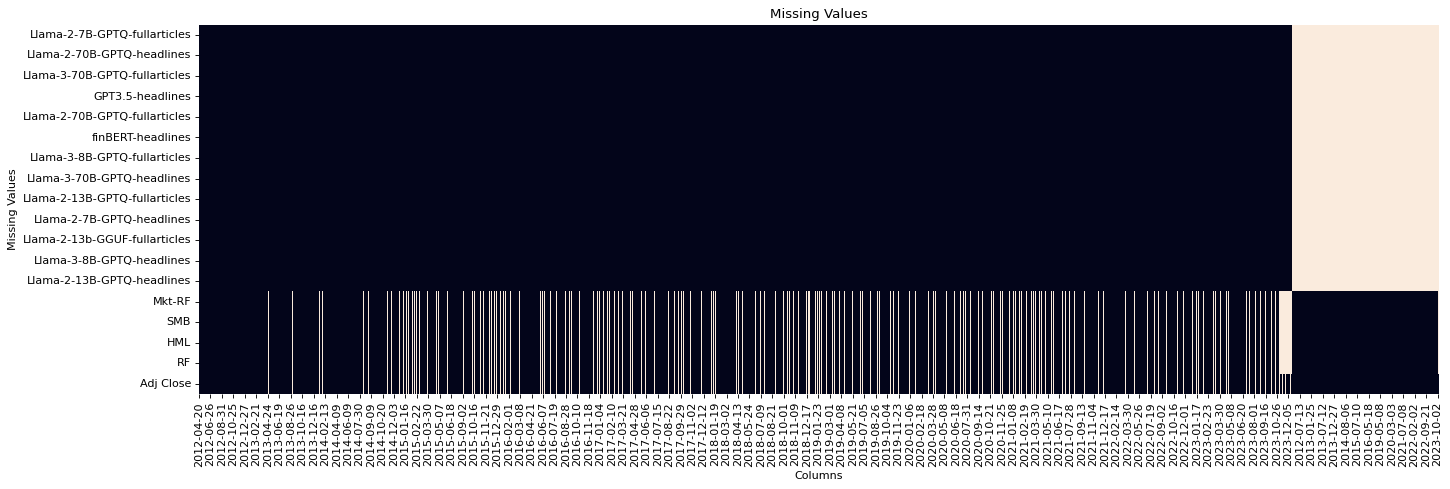

In [ ]:
# df_full[df_full.isna().any(axis=1)].index
plt.figure(figsize=(20, 6), dpi=80)
ax = plt.axes()
sns.heatmap(df_full.isna().transpose(), cbar=False, ax=ax)
plt.title("Missing Values", fontsize=12)
plt.xlabel("Columns", fontsize = 10) 
plt.ylabel("Missing Values", fontsize = 10)
plt.show()

# df_full.loc[datetime.date(2013, 4, 24):datetime.date(2013, 6, 19)]


Missing data processing:

- Impute null sentiment data as 3 (Neutral).
- Impute null market factors as mode values (due to non-normal distrubtion, check by df_full[ff3.columns].hist())
- Remove null values of stock price.

In [146]:
m_ind = df_full[df_full[colnames].isna().any(axis=1)].index
df_full.loc[m_ind, :]
df_full.loc[m_ind, colnames] = 3 
df_full.loc[m_ind, :]

,Llama-2-7B-GPTQ-fullarticles,Llama-2-70B-GPTQ-headlines,Llama-3-70B-GPTQ-fullarticles,GPT3.5-headlines,Llama-2-70B-GPTQ-fullarticles,finBERT-headlines,Llama-3-8B-GPTQ-fullarticles,Llama-3-70B-GPTQ-headlines,Llama-2-13B-GPTQ-fullarticles,Llama-2-7B-GPTQ-headlines,Llama-2-13b-GGUF-fullarticles,Llama-3-8B-GPTQ-headlines,Llama-2-13B-GPTQ-headlines,Mkt-RF,SMB,HML,RF,Adj Close
Time,,,,,,,,,,,,,,,,,,
2012-04-25,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,1.44,0.40,-0.98,0.000,68.868301
2012-04-27,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,0.35,0.69,-0.25,0.000,70.036766
2012-05-03,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,-0.92,-0.62,0.01,0.000,69.434807
2012-05-04,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,-1.62,-0.26,0.18,0.000,68.478813
2012-05-08,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,-0.41,0.33,0.32,0.000,68.160133
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-08-30,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,0.41,0.24,-0.45,0.020,90.913445
2023-10-02,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,-0.14,-0.92,-1.05,0.021,86.601295
2023-11-15,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,NaN,NaN,NaN,NaN,92.579559


In [142]:
# Imputing market factors
# Because SMB has 2 modes, take mean of the two. 
mod_val = df_full[ff3.columns].mode().mean()
mod_val

Mkt-RF   -0.050
SMB      -0.175
HML       0.230
RF        0.000
dtype: float64

In [147]:
m_ind2 = df_full[df_full[ff3.columns].isna().any(axis=1)].index
df_full.loc[m_ind2, :]
df_full.loc[m_ind2, ff3.columns] = df_full.loc[m_ind2, ff3.columns].fillna(mod_val)
df_full.loc[m_ind2, :]

,Llama-2-7B-GPTQ-fullarticles,Llama-2-70B-GPTQ-headlines,Llama-3-70B-GPTQ-fullarticles,GPT3.5-headlines,Llama-2-70B-GPTQ-fullarticles,finBERT-headlines,Llama-3-8B-GPTQ-fullarticles,Llama-3-70B-GPTQ-headlines,Llama-2-13B-GPTQ-fullarticles,Llama-2-7B-GPTQ-headlines,Llama-2-13b-GGUF-fullarticles,Llama-3-8B-GPTQ-headlines,Llama-2-13B-GPTQ-headlines,Mkt-RF,SMB,HML,RF,Adj Close
Time,,,,,,,,,,,,,,,,,,
2012-12-29,3.00,4.0,4.00,3.0,3.0,2.659485,3.0,5.0,4.00,3.0,3.0,3.0,3.0,-0.05,-0.175,0.23,0.0,NaN
2013-01-21,3.00,3.0,3.00,3.5,3.0,2.944976,3.0,3.0,3.00,3.0,3.0,3.0,3.0,-0.05,-0.175,0.23,0.0,NaN
2013-02-18,3.00,1.0,4.00,2.0,3.0,0.232526,5.0,1.0,4.00,3.0,3.0,1.0,3.0,-0.05,-0.175,0.23,0.0,NaN
2013-04-28,3.00,4.0,4.00,4.0,4.0,2.622436,4.0,5.0,4.00,3.0,4.0,4.0,3.0,-0.05,-0.175,0.23,0.0,NaN
2013-09-02,3.00,4.0,4.00,4.0,3.0,2.650930,4.0,3.0,4.00,4.0,3.0,3.0,3.0,-0.05,-0.175,0.23,0.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-15,4.00,3.5,4.00,4.0,4.5,3.081412,3.0,3.5,3.50,3.5,4.0,3.5,3.5,-0.05,-0.175,0.23,0.0,98.096123
2023-12-16,3.25,3.5,4.25,4.0,3.5,4.348631,3.0,3.5,3.25,3.5,4.0,3.5,3.0,-0.05,-0.175,0.23,0.0,NaN
2023-11-15,3.00,3.0,3.00,3.0,3.0,3.000000,3.0,3.0,3.00,3.0,3.0,3.0,3.0,-0.05,-0.175,0.23,0.0,92.579559


In [148]:
df_full.isna().sum()

Llama-2-7B-GPTQ-fullarticles       0
Llama-2-70B-GPTQ-headlines         0
Llama-3-70B-GPTQ-fullarticles      0
GPT3.5-headlines                   0
Llama-2-70B-GPTQ-fullarticles      0
finBERT-headlines                  0
Llama-3-8B-GPTQ-fullarticles       0
Llama-3-70B-GPTQ-headlines         0
Llama-2-13B-GPTQ-fullarticles      0
Llama-2-7B-GPTQ-headlines          0
Llama-2-13b-GGUF-fullarticles      0
Llama-3-8B-GPTQ-headlines          0
Llama-2-13B-GPTQ-headlines         0
Mkt-RF                             0
SMB                                0
HML                                0
RF                                 0
Adj Close                        418
dtype: int64

In [150]:
df_full.dropna(inplace=True)
df_full.isna().sum()

Llama-2-7B-GPTQ-fullarticles     0
Llama-2-70B-GPTQ-headlines       0
Llama-3-70B-GPTQ-fullarticles    0
GPT3.5-headlines                 0
Llama-2-70B-GPTQ-fullarticles    0
finBERT-headlines                0
Llama-3-8B-GPTQ-fullarticles     0
Llama-3-70B-GPTQ-headlines       0
Llama-2-13B-GPTQ-fullarticles    0
Llama-2-7B-GPTQ-headlines        0
Llama-2-13b-GGUF-fullarticles    0
Llama-3-8B-GPTQ-headlines        0
Llama-2-13B-GPTQ-headlines       0
Mkt-RF                           0
SMB                              0
HML                              0
RF                               0
Adj Close                        0
dtype: int64

In [151]:
df_full.to_csv('../data/df_full.csv')

### Training with walk forward

In [4]:
# predict N days after
PREDICT = 1 #5

WINDOW_SIZE = 30
TEST_SIZE = 0.2
VALIDATION_SPLIT = 0.625

torch.manual_seed(1)

Make percentage of return as outcome

In [5]:
df_full = pd.read_csv('../data/df_full.csv', index_col=0)
df_full['Per_ret'] = df_full['Adj Close'].pct_change()
df_full.head()

,Llama-2-7B-GPTQ-fullarticles,Llama-2-70B-GPTQ-headlines,Llama-3-70B-GPTQ-fullarticles,GPT3.5-headlines,Llama-2-70B-GPTQ-fullarticles,finBERT-headlines,Llama-3-8B-GPTQ-fullarticles,Llama-3-70B-GPTQ-headlines,Llama-2-13B-GPTQ-fullarticles,Llama-2-7B-GPTQ-headlines,Llama-2-13b-GGUF-fullarticles,Llama-3-8B-GPTQ-headlines,Llama-2-13B-GPTQ-headlines,Mkt-RF,SMB,HML,RF,Adj Close,Per_ret
Time,,,,,,,,,,,,,,,,,,,
2012-04-20,3.666667,3.333333,4.666667,3.333333,3.333333,2.935755,3.666667,3.333333,3.666667,4.000000,3.666667,3.000000,3.000000,0.11,0.54,-0.10,0.0,68.549644,NaN
2012-04-23,3.333333,3.333333,3.666667,3.666667,3.333333,2.869610,3.333333,3.666667,3.333333,3.333333,3.333333,3.333333,3.333333,-0.95,-0.56,0.15,0.0,67.522797,-0.014980
2012-04-24,3.000000,4.000000,3.000000,4.000000,3.000000,2.634394,3.000000,3.000000,4.000000,3.000000,4.000000,4.000000,3.000000,0.29,0.26,0.91,0.0,69.186981,0.024646
2012-04-26,3.000000,3.000000,3.000000,3.000000,3.000000,0.777762,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,0.75,-0.02,-0.06,0.0,69.470253,0.004094
2012-04-30,3.000000,3.000000,3.000000,3.000000,4.000000,2.604599,3.000000,3.000000,4.000000,3.000000,4.000000,3.000000,3.000000,-0.49,-0.57,0.00,0.0,69.328621,-0.002039


Practice with Llama-3-70B-GPTQ-fullarticles first since this seems to be the prediction with highest quality.

In [8]:
df_full = df_full.iloc[1:]
df_x = df_full[['Llama-3-70B-GPTQ-fullarticles', 'Mkt-RF', 'SMB', 'HML', 'RF']].values
df_y = df_full.iloc[:, -1].values

Scale input

In [22]:
from sklearn.preprocessing import MinMaxScaler

In [30]:
# scale the features
X_scaler = MinMaxScaler(feature_range=(-1, 1))
X_scaler.fit(df_x)
X_scaled = X_scaler.transform(df_x)

# scale the output
y_scaler = MinMaxScaler(feature_range=(-1, 1))
y_scaler.fit(df_y.reshape(len(df_y), 1))
y_scaled = y_scaler.transform(df_y.reshape(len(df_y), 1))

In [29]:
X = []
y = []
for i in range(WINDOW_SIZE, df_y.shape[0]):
    X.append(X_scaled[i - WINDOW_SIZE:i, :])
    y.append(y_scaled[i]) #[0]
X = np.array(X)
y = np.array(y)

#### Model

In [31]:
class LSTM(nn.Module):
    
    def __init__(self, num_classes, input_size, hidden_size, num_layers):
        super().__init__()
        self.num_classes = num_classes # output size
        self.num_layers = num_layers # number of recurrent layers in the lstm
        self.input_size = input_size # input size
        self.hidden_size = hidden_size # neurons in each lstm layer
        # LSTM model
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                            num_layers=num_layers, batch_first=True, dropout=0.2) # lstm
        self.fc_1 =  nn.Linear(hidden_size, 128) # fully connected 
        self.fc_2 = nn.Linear(128, num_classes) # fully connected last layer
        self.relu = nn.ReLU()
        
    def forward(self,x):
        # print('x.shape', x.shape)
        # hidden state
        h_0 = torch.zeros(self.num_layers, x.shape[0], self.hidden_size) #x.size(0)
        # cell state
        c_0 = torch.zeros(self.num_layers, x.shape[0], self.hidden_size)
        # propagate input through LSTM
        output, (hn, cn) = self.lstm(x, (h_0, c_0)) # (input, hidden, and internal state)
        hn = hn.view(-1, self.hidden_size) # reshaping the data for Dense layer next
        out = self.relu(hn)
        out = self.fc_1(out) # first dense
        out = self.relu(out) # relu
        out = self.fc_2(out) # final output
        return out

#### Walk forward with purge & embargo


May refer to: https://github.com/skfolio/skfolio

Training loop with early stopping

In [36]:
# build the model
# model = LSTM()
# seq.double()

def model_fit(model, train_set, validation_split, epoch_num, batch_size):
    train_X, train_y = train_set
    train_X = torch.from_numpy(train_X).float().transpose(2, 1) #?
    train_y = torch.from_numpy(train_y).float()
    split_point = int(len(train_y) * validation_split)
    
    train_X, train_y = train_X[: -split_point], train_y[: -split_point]
    print('trainx train y shape', train_X.shape, train_y.shape)
    val_X, val_y = train_X[-split_point:], train_y[-split_point:]
    
    criterion = nn.MSELoss()

    # use LBFGS as optimizer since we can load the whole data to train
    optimizer = optim.Adam(model.parameters())

    loss_list = []
    val_loss_list = []

    # epoch_num = 50

    # Initialize Variables for EarlyStopping
    best_loss = float('inf')
    best_model_weights = None
    patience = 10

    # begin to train
    for epoch in range(epoch_num):
    
        model.train() ##
        
        def closure():
            optimizer.zero_grad()
            # print('train_X', train_X)
            out = model(train_X)
            print('out and train shape', out.shape, train_y.shape)
            loss = criterion(out, train_y)
            # print('loss:', loss.data.numpy())
            loss_list.append(loss.data.numpy())
            loss.backward()
            return loss
        
        loss = closure()
        if epoch % 10 == 0:
            print('epoch : ', epoch, ' loss : ', loss.item())
        
        optimizer.step(closure)

        # Validation
        model.eval()  # Set model to evaluation mode
        with torch.no_grad():  # Disable gradient calculation for validation
            val_outputs = model(val_X)
            val_loss = criterion(val_outputs, val_y.float())
            val_loss_list.append(val_loss.numpy())
            
        # Early stopping
        if val_loss < best_loss:
            best_loss = val_loss
            best_model_weights = copy.deepcopy(model.state_dict())  # Deep copy here      
            patience = 10  # Reset patience counter
        else:
            patience -= 1
            if patience == 0:
                break
            
    # Load the best model weights
    model.load_state_dict(best_model_weights)
    return loss_list, val_loss_list

#   # begin to predict
#     future = 1000
#     pred = seq(test_X, future=future)
#     pred = seq(test_X)
#     loss = criterion(pred, test_y)
# #     print('test loss:', loss.data.numpy()[0])
#     test_loss_list.append(loss.data.numpy()[0])

#     y = pred.data.numpy()

In [ ]:
n_train = 500
n_test = 500
n_airgap = 200
hidden_size = 5
num_layers = 3

# def walk_forward_purge_embargo(n_train, n_test, n_airgap):
time_backtest = []
time_backtest = np.array(time_backtest)
time_backtest = time_backtest.astype("datetime64", copy=False)

pred_backtest_lstm = []
ret_backtest = []
actual = []

# model_lstm = LSTM(PREDICT, X.shape[1], hidden_size, num_layers)

for i in range(0, len(y) - n_train - n_airgap, n_test):
    # print(len(pred_backtest_lstm), len(pred_backtest_cnn), len(ret_backtest), len(actual))
    X_train_lstm, X_test_lstm = X[i : i + n_train], X[i + n_train + n_airgap : i + n_train + n_test + n_airgap]

    y_train, y_test = y[i : i + n_train], y[i + n_train + n_airgap : i + n_train + n_test + n_airgap]
    test_time = df_full.index.values[i + (n_train) : i + n_train + n_test]
    Ret_vector = df_full.iloc[i + (n_train) : i + n_train + n_test, 1:2].values
    # y_benchmark = np.mean(y_train)

    # torch.manual_seed(1234)

    # Performance of LSTM
    model_lstm = LSTM(PREDICT, X_train_lstm.shape[1], hidden_size, num_layers)
    
    # for i in range(len(X_train_lstm)): #?
    train_loss, val_loss = model_fit(model_lstm, 
                                     (X_train_lstm, y_train), 
                                     validation_split=VALIDATION_SPLIT, epoch_num=100, batch_size=64)
    # print("train_loss, val_loss", train_loss, val_loss)
    
    # score_lstm = model_lstm.evaluate(X_test_lstm, y_test, batch_size=n_test, verbose=0)
    # y_pred_lstm = model_lstm.predict(X_test_lstm, verbose=0)
    
    X_test_lstm = torch.from_numpy(X_test_lstm).float().transpose(2,1) #?
    y_pred_lstm = model_lstm(X_test_lstm)
    print(
        "ite ",
        i / n_test,
        " -- MSE - LSTM: ",
        # np.round(score_lstm, 4),  #[0] #?
    
    )

    time_backtest = np.append(time_backtest, test_time.flatten())
    pred_backtest_lstm = np.append(pred_backtest_lstm, y_pred_lstm.detach().numpy().flatten())
    ret_backtest = np.append(ret_backtest, Ret_vector.flatten())
    actual = np.append(actual, y_test.flatten())

# return time_backtest, pred_backtest_lstm, ret_backtest, actual

# time_backtest, pred_backtest_lstm_3a, pred_backtest_cnn_3a, ret_backtest_3a, actual = walk_forward_purge_embargo(n_train, n_test, n_airgap)
# df_predictions = pd.DataFrame(
#     {"Pred_lstm": pred_backtest_lstm_3a, "Date": time_backtest[:1143], "Ret": ret_backtest_3a[:1143]}
# )
# df_predictions.Date = pd.to_datetime(df_predictions.Date, format="%YYYY-%mm-%dd")
# df_res_3a = df_predictions

### Evaluation

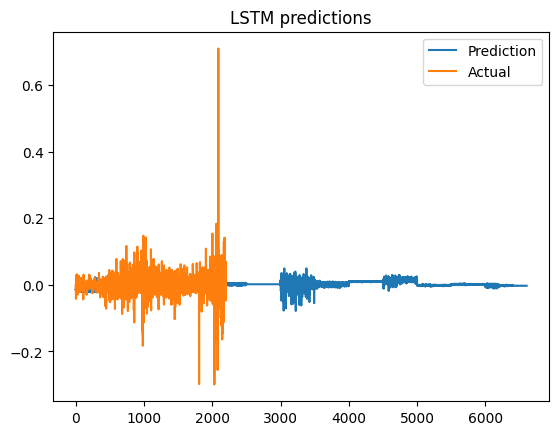

In [28]:
# fig, axs = plt.subplots(2, 1, figsize=(15, 10))

plt.title("LSTM predictions")
plt.plot(pred_backtest_lstm[PREDICT:])
plt.plot(actual)
plt.legend(["Prediction", "Actual"])

In [ ]:
def backtest(predictions, test_start_date):
    """
    Based on the given predictions, calculate the strategy return and the buy and hold returns.

    The strategy will long the stocks for {PREDICT} days if the predicted {PREDICT}-day
    return is positive, and short the stocks if negative. Buy and hold strategy will just long
    all the stocks throughout the timeline.

    """
    num_days = len(predictions)
    strat_decision = []
    bah_decision = []

    for i in range(0, num_days, PREDICT):
        strat_decision.extend([[1 if predictions[i] >= 0 else -1]] * PREDICT)
        bah_decision.extend([[1]] * PREDICT)

    pct_returns = np.stack([df["Ret -1D"][test_start_date:][WINDOW_SIZE:]], axis=1)
    length = min(len(pct_returns), len(strat_decision))
    strat_returns = pct_returns[:length] * strat_decision[:length]
    bah_returns = pct_returns[:length] * bah_decision[:length]

    strat_daily_returns = pd.Series(np.cumprod((strat_returns + 1), axis=0).mean(axis=1))
    strat_daily_returns.index = list(df["Ret -1D"][test_start_date:][WINDOW_SIZE:].index)[:length]
    bah_daily_returns = pd.Series(np.cumprod((bah_returns + 1), axis=0).mean(axis=1))
    bah_daily_returns.index = strat_daily_returns.index

    return strat_daily_returns, bah_daily_returns

In [ ]:
# get the backtest returns and plot them
strat_daily_returns, bah_daily_returns = backtest(LSTM_PREDICTION_OOS, TEST_SET_START)

ax = plt.gca()
ax.set_title("LSTM Strategy Backtest Results")
ax.plot(strat_daily_returns)
ax.plot(bah_daily_returns)
ax.legend(["Strategy", "Buy-and-hold"])
plt.show()

In [ ]:
final_return = np.prod(1 + strat_daily_returns) - 1
buy_return = np.prod(1 + bah_daily_returns) - 1

print("Strategy Return =", final_return * 100, "%")
print("Buy and Hold Return =", buy_return * 100, "%")

Evaluate the performance of the trading strategy based on the predictions: long the ETF if the predicted return is positive and short otherwise.

In [ ]:
def evaluated_and_plot(df_res, pred_column):
    df_res["Positions"] = np.where(df_res[pred_column] > 0.0, 1, -1)
    df_res["Positions_shift"] = df_res["Positions"].shift(1)
    df_res["Strat_ret"] = df_res["Positions"].shift(1) * df_res["Ret"]
    df_res["Positions_L"] = df_res["Positions"].shift(1)
    df_res["Positions_L"][df_res["Positions_L"] == -1] = 0
    df_res["Strat_ret_L"] = df_res["Positions_L"] * df_res["Ret"]

    Final_Return_L = np.prod(1 + df_res["Strat_ret_L"]) - 1
    Final_Return = np.prod(1 + df_res["Strat_ret"]) - 1
    Buy_Return = np.prod(1 + df_res["Ret"]) - 1

    print(
        "Strat Return =",
        np.round(Final_Return * 100, 2),
        "% ,",
        "Sharpe ratio =",
        np.round(
            np.sqrt(24.0 * 365.0)
            * np.mean(df_res["Strat_ret"])
            / np.std(df_res["Strat_ret"]),
            2,
        ),
    )
    print(
        "Buy and Hold Return =",
        np.round(Buy_Return * 100, 2),
        "%, ",
        "Sharpe ratio =",
        np.round(np.sqrt(24.0 * 365.0) * np.mean(df_res["Ret"]) / np.std(df_res["Ret"]), 2),
    )

    # Plotting
    df_res["CumRet"] = df_res["Strat_ret"].expanding().apply(lambda x: np.prod(1 + x) - 1)
    # df_res["CumRet_L"] = (
    #     df_res["Strat_ret_L"].expanding().apply(lambda x: np.prod(1 + x) - 1)
    # )
    df_res["bhRet"] = df_res["Ret"].expanding().apply(lambda x: np.prod(1 + x) - 1)

    fig = plt.figure(figsize=(12, 6))
    ax = plt.gca()
    df_res.plot(x="Date", y="bhRet", label="Buy&Hold", ax=ax)
    # df_res.plot(x="Date", y="CumRet_L", label="Strat Only Long - " + pred_column, ax=ax)
    df_res.plot(x="Date", y="CumRet", label="Strat Long/Short - " + pred_column, ax=ax)
    plt.xlabel("date")
    plt.ylabel("Cumulative Returns")
    plt.grid()
    plt.show()

    df_res["trade_bin"] = df_res["Positions"].diff().abs()
    df_res["trade_bin"] = df_res["trade_bin"] / 2

evaluated_and_plot(df_res_2a, "Pred_lstm")